# 🔍 Grid Search de Hiperparámetros para LSTM (Versión Local)

Este notebook realiza una búsqueda exhaustiva de hiperparámetros para el modelo LSTM de reconocimiento de gestos.

**Para ejecutar localmente:**
1. **IMPORTANTE:** Ejecuta primero la celda de instalación de TensorFlow (celda siguiente)
2. Si tienes GPU NVIDIA, se usará automáticamente para acelerar el entrenamiento
3. Asegúrate de tener todos los archivos `.npy` en `assets/data/keypoints/`
4. Asegúrate de tener `words.json` en `models/words.json`
5. Ejecuta las celdas en orden
6. Los resultados se guardarán en `resultsLSTM.csv` en el directorio actual

**Archivos generados para el informe:**
- `resultsLSTM.csv` - Todos los resultados del grid search ordenados por mejor rendimiento


In [8]:
# ========================================
# INSTALACIÓN DE TENSORFLOW CON GPU NVIDIA
# ========================================

# Método 1: Instalar TensorFlow (incluye soporte GPU si CUDA está instalado)
print("🚀 Instalando TensorFlow...")
print("⏳ Esto puede tardar varios minutos...\n")

# Instalar TensorFlow (detectará GPU automáticamente si CUDA está instalado)
%pip install tensorflow --upgrade

print("\n✅ TensorFlow instalado!")
print("\n💡 Para usar GPU NVIDIA, necesitas:")
print("   1. Drivers NVIDIA actualizados (descarga desde nvidia.com)")
print("   2. CUDA Toolkit 11.2 o superior (descarga desde developer.nvidia.com/cuda-downloads)")
print("   3. cuDNN 8.1+ (descarga desde developer.nvidia.com/cudnn)")
print("\n📝 Si no tienes CUDA instalado, TensorFlow funcionará en CPU")
print("   El entrenamiento será más lento pero funcionará correctamente")


🚀 Instalando TensorFlow...
⏳ Esto puede tardar varios minutos...

  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.76.0-cp313-cp313-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached ml_dtypes-0.5.3-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached tensorbo


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import json
from pathlib import Path
from itertools import product
import warnings
import os
warnings.filterwarnings("ignore")

# ========================================
# CONFIGURACIÓN Y VERIFICACIÓN DE GPU
# ========================================
print("🔧 Verificando dispositivos disponibles...")
print(f"TensorFlow version: {tf.__version__}")

# Listar dispositivos disponibles
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')

print(f"\n📱 Dispositivos detectados:")
print(f"   CPUs: {len(cpus)}")
print(f"   GPUs: {len(gpus)}")

if gpus:
    print(f"\n✅ {len(gpus)} GPU(s) NVIDIA detectada(s):")
    for i, gpu in enumerate(gpus):
        print(f"   GPU {i}: {gpu.name}")
        
        # Obtener detalles de la GPU
        try:
            gpu_details = tf.config.experimental.get_device_details(gpu)
            if gpu_details:
                print(f"      Detalles: {gpu_details}")
        except:
            pass
    
    # Configurar crecimiento de memoria para evitar errores
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("\n✅ GPU configurada para crecimiento de memoria dinámico")
    except RuntimeError as e:
        print(f"\n⚠️  Error configurando GPU: {e}")
        print("   Intentando otra configuración...")
        try:
            # Configuración alternativa
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
            )
            print("✅ GPU configurada con límite de memoria")
        except Exception as e2:
            print(f"⚠️  No se pudo configurar GPU: {e2}")
    
    # Verificar que TensorFlow pueda usar la GPU
    print("\n🧪 Verificando uso de GPU...")
    try:
        with tf.device('/GPU:0'):
            test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            result = tf.matmul(test_tensor, test_tensor)
            print(f"   Resultado del test: {result.numpy()}")
        print("✅ GPU funcionando correctamente")
        print("🚀 TensorFlow usará GPU para acelerar el entrenamiento (~4x más rápido)")
    except Exception as e:
        print(f"⚠️  Error usando GPU: {e}")
        print("   Se usará CPU como respaldo")
else:
    print("\n⚠️  No se detectaron GPUs")
    print("   TensorFlow usará CPU para los cálculos")
    print("\n💡 Para habilitar GPU NVIDIA:")
    print("   1. Instala drivers NVIDIA más recientes")
    print("   2. Instala CUDA Toolkit 11.2+ desde: https://developer.nvidia.com/cuda-downloads")
    print("   3. Instala cuDNN desde: https://developer.nvidia.com/cudnn")
    print("   4. Reinicia el kernel de Jupyter después de instalar")

# Importar constantes desde app_constants
from app_constants import KEYPOINTS_PATH, MODEL_FRAMES, LENGTH_KEYPOINTS, MODEL_DIR, WORDS_JSON_PATH

print(f"\n📁 Rutas configuradas:")
print(f"   KEYPOINTS_PATH: {KEYPOINTS_PATH}")
print(f"   WORDS_JSON_PATH: {WORDS_JSON_PATH}")
print(f"   MODEL_FRAMES: {MODEL_FRAMES}")
print(f"   LENGTH_KEYPOINTS: {LENGTH_KEYPOINTS}")
print("\n✅ Todas las librerías cargadas correctamente")


🔧 Verificando dispositivos disponibles...
TensorFlow version: 2.20.0

📱 Dispositivos detectados:
   CPUs: 1
   GPUs: 0

⚠️  No se detectaron GPUs
   TensorFlow usará CPU para los cálculos

💡 Para habilitar GPU NVIDIA:
   1. Instala drivers NVIDIA más recientes
   2. Instala CUDA Toolkit 11.2+ desde: https://developer.nvidia.com/cuda-downloads
   3. Instala cuDNN desde: https://developer.nvidia.com/cudnn
   4. Reinicia el kernel de Jupyter después de instalar

📁 Rutas configuradas:
   KEYPOINTS_PATH: c:\Users\geide\Documents\GitHub\Tesis\gesto_releasev1\assets\data\keypoints
   WORDS_JSON_PATH: c:\Users\geide\Documents\GitHub\Tesis\gesto_releasev1\models\words.json
   MODEL_FRAMES: 15
   LENGTH_KEYPOINTS: 1662

✅ Todas las librerías cargadas correctamente


In [10]:
# Cargar etiquetas y verificar archivos disponibles
print("🔍 Verificando archivos disponibles...")
print(f"📂 Contenido de {KEYPOINTS_PATH}:")
if os.path.exists(KEYPOINTS_PATH):
    files = os.listdir(KEYPOINTS_PATH)
    npy_files = [f for f in files if f.endswith('.npy')]
    print(f"   Archivos .npy encontrados: {len(npy_files)}")
    for f in npy_files[:10]:  # Mostrar primeros 10
        print(f"   - {f}")
    if len(npy_files) > 10:
        print(f"   ... y {len(npy_files) - 10} más")
else:
    print(f"   ⚠️  La carpeta {KEYPOINTS_PATH} no existe")
    print(f"   💡 Verifica que los archivos .npy estén en la ubicación correcta")

# Cargar etiquetas
if os.path.exists(WORDS_JSON_PATH):
    with open(WORDS_JSON_PATH, 'r', encoding='utf-8') as f:
        gestures = json.load(f)["word_ids"]
    print(f"\n✅ Etiquetas cargadas desde {WORDS_JSON_PATH}")
else:
    gestures = ['hola-der', 'dias-gen', 'paz-der']
    print(f"\n⚠️  {WORDS_JSON_PATH} no encontrado, usando gestos por defecto")

print(f"\n🏷️  Gestos a entrenar: {gestures}")
print(f"📊 Total de clases: {len(gestures)}")

# Cargar secuencias desde archivos .npy
def load_sequences(gestures):
    seqs, labels = [], []
    for idx, g in enumerate(gestures):
        file = os.path.join(KEYPOINTS_PATH, f"{g}.npy")
        if not os.path.exists(file):
            print(f"⚠️  Falta {file}")
            continue
        arr = np.load(file, allow_pickle=True)
        # arr esperado: (N, T, D) o (T, D)
        if arr.ndim == 2 and arr.shape == (MODEL_FRAMES, LENGTH_KEYPOINTS):
            arr = arr[np.newaxis, ...]
        if arr.ndim != 3 or arr.shape[-1] != LENGTH_KEYPOINTS:
            print(f"⚠️  {os.path.basename(file)} forma inesperada {arr.shape}, se omite")
            continue
        for seq in arr:
            seqs.append(seq)
            labels.append(idx)
    return seqs, labels

sequences, labels = load_sequences(gestures)
print(f"✅ Cargadas {len(sequences)} secuencias de {len(gestures)} gestos")


🔍 Verificando archivos disponibles...
📂 Contenido de c:\Users\geide\Documents\GitHub\Tesis\gesto_releasev1\assets\data\keypoints:
   Archivos .npy encontrados: 18
   - adios.npy
   - bien.npy
   - bienvenido.npy
   - buenas-noches.npy
   - buenas-tardes.npy
   - buenos-dias.npy
   - como-estas.npy
   - con-gusto.npy
   - feliz-cumpleanos.npy
   - gracias.npy
   ... y 8 más

✅ Etiquetas cargadas desde c:\Users\geide\Documents\GitHub\Tesis\gesto_releasev1\models\words.json

🏷️  Gestos a entrenar: ['bien', 'feliz-cumpleanos', 'buenas-noches', 'mal', 'como-estas', 'gracias', 'mas-o-menos', 'con-gusto', 'lo-siento', 'buenos-dias', 'bienvenido', 'buenas-tardes', 'permiso', 'adios', 'perdon', 'sordo', 'hola', 'por-favor']
📊 Total de clases: 18
✅ Cargadas 579 secuencias de 18 gestos


In [11]:
# Preparar datos
X = pad_sequences(sequences, maxlen=int(MODEL_FRAMES), padding='pre', truncating='post', dtype='float32')
y = to_categorical(labels, num_classes=len(gestures))

print(f"📦 Forma de datos:")
print(f"   X: {X.shape} (samples, frames, keypoints)")
print(f"   y: {y.shape} (samples, classes)")


📦 Forma de datos:
   X: (579, 15, 1662) (samples, frames, keypoints)
   y: (579, 18) (samples, classes)


In [12]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📊 Datos de entrenamiento: {X_train.shape}")
print(f"📊 Datos de prueba: {X_test.shape}")


📊 Datos de entrenamiento: (463, 15, 1662)
📊 Datos de prueba: (116, 15, 1662)


In [13]:
# Definir grid de parámetros (basado en train_lstm_node_v4.js)
# Versión práctica para grid search (balance entre cobertura y tiempo)
param_grid = {
    'lstm_units_1': [64, 128, 256],          # Unidades de la primera capa LSTM
    'lstm_units_2': [32, 64, 128],           # Unidades de la segunda capa LSTM
    'dense_units': [32, 64],                 # Unidades de la capa Dense
    'dropout_rate': [0.3, 0.4, 0.5],        # Tasa de dropout
    'l2_regularizer': [0.001, 0.01],        # Factor de regularización L2
    'learning_rate': [0.0001, 0.001],       # Learning rate del optimizador
    'batch_size': [32, 64],                  # Tamaño del batch
}

print("📋 Grid de parámetros definido:")
for key, values in param_grid.items():
    print(f"   - {key}: {values}")

# Calcular total de combinaciones
from itertools import product
keys = param_grid.keys()
values = param_grid.values()
total_combinations = len(list(product(*values)))
print(f"\n📊 Total de combinaciones: {total_combinations}")


📋 Grid de parámetros definido:
   - lstm_units_1: [64, 128, 256]
   - lstm_units_2: [32, 64, 128]
   - dense_units: [32, 64]
   - dropout_rate: [0.3, 0.4, 0.5]
   - l2_regularizer: [0.001, 0.01]
   - learning_rate: [0.0001, 0.001]
   - batch_size: [32, 64]

📊 Total de combinaciones: 432


In [14]:
# Función para construir el modelo LSTM
def build_lstm_model(num_classes, lstm_units_1, lstm_units_2, dense_units, 
                     dropout_rate, l2_regularizer, learning_rate):
    """
    Construye el modelo LSTM con los hiperparámetros especificados.
    Basado en train_lstm_node_v4.js
    """
    tf.keras.backend.clear_session()  # Limpiar sesión previa
    
    model = Sequential()
    model.add(Input(shape=(int(MODEL_FRAMES), LENGTH_KEYPOINTS)))
    
    # LSTM 1
    model.add(LSTM(
        lstm_units_1,
        return_sequences=True,
        kernel_regularizer=l2(l2_regularizer)
    ))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # LSTM 2
    model.add(LSTM(
        lstm_units_2,
        return_sequences=False,
        kernel_regularizer=l2(l2_regularizer)
    ))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Dense
    model.add(Dense(
        dense_units,
        activation='relu',
        kernel_regularizer=l2(l2_regularizer)
    ))
    model.add(Dropout(dropout_rate))
    
    # Output
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilar
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✅ Función build_lstm_model definida")


✅ Función build_lstm_model definida


In [15]:
# Función para evaluar un conjunto de parámetros
def evaluate_params(params, X_train, y_train, X_test, y_test, num_classes, epochs=100, verbose=0):
    """
    Entrena y evalúa un modelo con los parámetros dados.
    Returns: dict con métricas
    """
    try:
        # Asegurar que el modelo se construya y entrene en GPU (si está disponible)
        gpus = tf.config.list_physical_devices('GPU')
        device = '/GPU:0' if gpus else '/CPU:0'
        
        with tf.device(device):
            model = build_lstm_model(
                num_classes=num_classes,
                lstm_units_1=params['lstm_units_1'],
                lstm_units_2=params['lstm_units_2'],
                dense_units=params['dense_units'],
                dropout_rate=params['dropout_rate'],
                l2_regularizer=params['l2_regularizer'],
                learning_rate=params['learning_rate']
            )
            
            # Callbacks
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=0
            )
            
            # Entrenar (usando GPU si está disponible)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=epochs,
                batch_size=params['batch_size'],
                callbacks=[early_stopping],
                verbose=verbose
            )
        
        # Obtener mejores métricas (después del early stopping)
        best_val_loss = min(history.history['val_loss'])
        best_val_acc = max(history.history['val_accuracy'])
        best_train_acc = max(history.history['accuracy'])
        best_train_loss = min(history.history['loss'])
        epochs_used = len(history.history['loss'])
        
        # Evaluar en test
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        
        # Limpiar modelo
        del model
        tf.keras.backend.clear_session()
        
        return {
            'val_loss': best_val_loss,
            'val_accuracy': best_val_acc,
            'train_loss': best_train_loss,
            'train_accuracy': best_train_acc,
            'test_loss': test_loss,
            'test_accuracy': test_acc,
            'epochs_used': epochs_used,
            'status': 'success'
        }
        
    except Exception as e:
        return {
            'val_loss': np.nan,
            'val_accuracy': np.nan,
            'train_loss': np.nan,
            'train_accuracy': np.nan,
            'test_loss': np.nan,
            'test_accuracy': np.nan,
            'epochs_used': 0,
            'status': f'error: {str(e)}'
        }

print("✅ Función evaluate_params definida")


✅ Función evaluate_params definida


In [16]:
# Grid Search - ADVERTENCIA: Esto puede tardar mucho tiempo
print(f"🔍 Iniciando Grid Search...")
print(f"📊 Total de combinaciones: {total_combinations}")

# Estimar tiempo según dispositivo disponible
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    time_per_combination = 0.5  # ~30 segundos con GPU NVIDIA
    device_info = f"GPU NVIDIA ({gpus[0].name})"
    estimated_hours = (total_combinations * time_per_combination) / 3600
    print(f"🖥️  Dispositivo: {device_info}")
    print(f"⏱️  Tiempo estimado: ~{estimated_hours:.1f} horas ({estimated_hours*60:.0f} minutos)")
    print(f"   Velocidad: ~{time_per_combination*60:.0f} segundos por combinación")
else:
    time_per_combination = 2.0  # ~2 minutos con CPU
    device_info = "CPU"
    estimated_hours = (total_combinations * time_per_combination) / 3600
    print(f"🖥️  Dispositivo: {device_info} (más lento)")
    print(f"⏱️  Tiempo estimado: ~{estimated_hours:.1f} horas ({estimated_hours*60:.0f} minutos)")
    print(f"   💡 Usar GPU NVIDIA puede reducir el tiempo a ~1/4 del tiempo actual")

print()

results = []
best_accuracy = 0
best_params = None

keys = list(param_grid.keys())
values = list(param_grid.values())
combinations = [dict(zip(keys, v)) for v in product(*values)]

for i, params in enumerate(combinations, 1):
    print(f"[{i}/{total_combinations}] Probando: {params}")
    
    metrics = evaluate_params(
        params, X_train, y_train, X_test, y_test, 
        num_classes=len(gestures), 
        epochs=100,
        verbose=0
    )
    
    # Combinar params y metrics
    result = {**params, **metrics}
    results.append(result)
    
    if metrics['status'] == 'success':
        print(f"   ✅ Val Acc: {metrics['val_accuracy']:.4f}, Test Acc: {metrics['test_accuracy']:.4f}")
        if metrics['val_accuracy'] > best_accuracy:
            best_accuracy = metrics['val_accuracy']
            best_params = params
            print(f"   🎯 ¡Nuevo mejor modelo! Val Acc: {best_accuracy:.4f}\n")
    else:
        print(f"   ❌ Error: {metrics['status']}\n")

print(f"\n✅ Grid Search completado")
print(f"🎯 Mejor val_accuracy: {best_accuracy:.4f}")
print(f"📋 Mejores parámetros: {best_params}")


🔍 Iniciando Grid Search...
📊 Total de combinaciones: 432
🖥️  Dispositivo: CPU (más lento)
⏱️  Tiempo estimado: ~0.2 horas (14 minutos)
   💡 Usar GPU NVIDIA puede reducir el tiempo a ~1/4 del tiempo actual

[1/432] Probando: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'l2_regularizer': 0.001, 'learning_rate': 0.0001, 'batch_size': 32}

   ✅ Val Acc: 0.8362, Test Acc: 0.8190
   🎯 ¡Nuevo mejor modelo! Val Acc: 0.8362

[2/432] Probando: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'l2_regularizer': 0.001, 'learning_rate': 0.0001, 'batch_size': 64}
   ✅ Val Acc: 0.7759, Test Acc: 0.7759
[3/432] Probando: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'l2_regularizer': 0.001, 'learning_rate': 0.001, 'batch_size': 32}
   ✅ Val Acc: 0.8621, Test Acc: 0.8621
   🎯 ¡Nuevo mejor modelo! Val Acc: 0.8621

[4/432] Probando: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dense_units': 32, 'dropout_rat

In [17]:
# Convertir resultados a DataFrame y guardar
df = pd.DataFrame(results)

# Ordenar por val_accuracy (mejor primero)
df['rank'] = df['val_accuracy'].rank(ascending=False, method='min')
df = df.sort_values(by='rank', ascending=True)

# Guardar a CSV (en el directorio actual) - ARCHIVO PARA EL INFORME
output_file = 'resultsLSTM.csv'
df.to_csv(output_file, index=False)
print(f"✅ Resultados guardados en: {output_file}")
print(f"📄 Este archivo contiene todos los resultados para el informe\n")

# Mostrar resumen estadístico
print("="*80)
print("📊 RESUMEN DE RESULTADOS (Para el Informe)")
print("="*80)
print(f"Total de combinaciones probadas: {len(df)}")
print(f"Combinaciones exitosas: {len(df[df['status'] == 'success'])}")
print(f"Combinaciones con error: {len(df[df['status'] != 'success'])}")

if len(df[df['status'] == 'success']) > 0:
    print(f"\n📈 Estadísticas de Validation Accuracy:")
    print(df[df['status'] == 'success']['val_accuracy'].describe())
    
    print(f"\n🏆 Top 5 mejores modelos:")
    top5_cols = ['rank', 'lstm_units_1', 'lstm_units_2', 'dense_units', 'dropout_rate', 
                 'l2_regularizer', 'learning_rate', 'batch_size', 'val_accuracy', 'test_accuracy']
    print(df[df['status'] == 'success'][top5_cols].head().to_string(index=False))
    
    # Guardar también un resumen de los mejores modelos
    summary_file = 'resultsLSTM_summary.txt'
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("RESUMEN DE GRID SEARCH LSTM\n")
        f.write("="*80 + "\n\n")
        f.write(f"Total de combinaciones probadas: {len(df)}\n")
        f.write(f"Combinaciones exitosas: {len(df[df['status'] == 'success'])}\n")
        f.write(f"Combinaciones con error: {len(df[df['status'] != 'success'])}\n\n")
        f.write("Top 10 mejores modelos:\n")
        f.write("-"*80 + "\n")
        f.write(df[df['status'] == 'success'][top5_cols].head(10).to_string(index=False))
        f.write("\n\n")
        f.write("Estadísticas completas:\n")
        f.write("-"*80 + "\n")
        f.write(str(df[df['status'] == 'success']['val_accuracy'].describe()))
    
    print(f"\n✅ Resumen detallado guardado en: {summary_file}")

print("="*80)
print("💾 ARCHIVOS GENERADOS PARA EL INFORME:")
print(f"   1. {output_file} - Resultados completos en CSV")
if len(df[df['status'] == 'success']) > 0:
    print(f"   2. {summary_file} - Resumen de mejores modelos")
print("="*80)


✅ Resultados guardados en: resultsLSTM.csv
📄 Este archivo contiene todos los resultados para el informe

📊 RESUMEN DE RESULTADOS (Para el Informe)
Total de combinaciones probadas: 432
Combinaciones exitosas: 432
Combinaciones con error: 0

📈 Estadísticas de Validation Accuracy:
count    432.000000
mean       0.749940
std        0.136555
min        0.405172
25%        0.653017
50%        0.741379
75%        0.853448
max        1.000000
Name: val_accuracy, dtype: float64

🏆 Top 5 mejores modelos:
 rank  lstm_units_1  lstm_units_2  dense_units  dropout_rate  l2_regularizer  learning_rate  batch_size  val_accuracy  test_accuracy
  1.0           256           128           32           0.3           0.001         0.0001          32      1.000000       1.000000
  1.0            64           128           64           0.3           0.001         0.0001          32      1.000000       1.000000
  3.0           256            64           64           0.3           0.001         0.0001          

📊 Resumen de resultados:
   - Total de combinaciones probadas: 432
   - Combinaciones exitosas: 432
   - Combinaciones con error: 0

📈 Estadísticas de val_accuracy:
count    432.000000
mean       0.749940
std        0.136555
min        0.405172
25%        0.653017
50%        0.741379
75%        0.853448
max        1.000000
Name: val_accuracy, dtype: float64


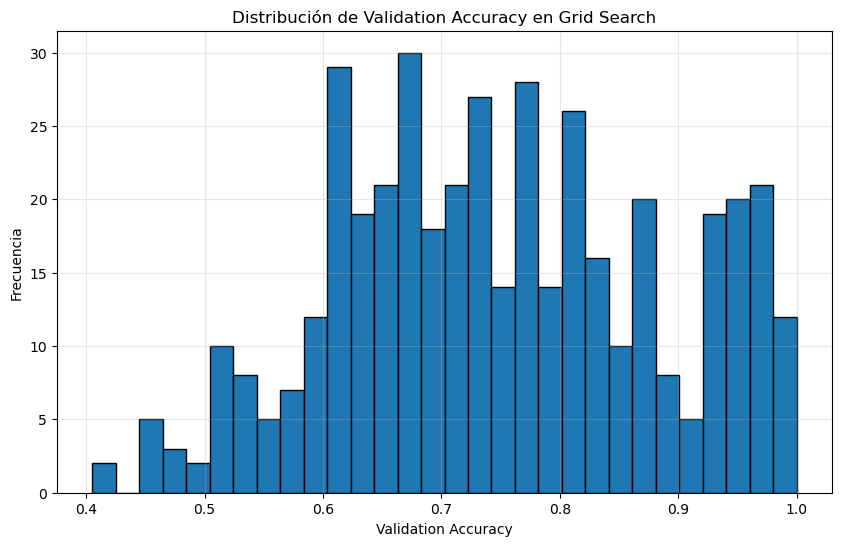

In [18]:
# Visualizar resultados (opcional)
if 'df' in locals():
    print("📊 Resumen de resultados:")
    print(f"   - Total de combinaciones probadas: {len(df)}")
    print(f"   - Combinaciones exitosas: {len(df[df['status'] == 'success'])}")
    print(f"   - Combinaciones con error: {len(df[df['status'] != 'success'])}")
    print(f"\n📈 Estadísticas de val_accuracy:")
    print(df['val_accuracy'].describe())
    
    # Gráfico de distribución de accuracies
    plt.figure(figsize=(10, 6))
    plt.hist(df[df['status'] == 'success']['val_accuracy'], bins=30, edgecolor='black')
    plt.xlabel('Validation Accuracy')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Validation Accuracy en Grid Search')
    plt.grid(True, alpha=0.3)
    plt.show()


## ⚠️ NOTA: Grid Search

El grid search actual tiene **432 combinaciones** (3×3×2×3×2×2×2), lo cual puede tardar varias horas dependiendo de tu hardware.

- **Estimado**: ~14 horas (asumiendo ~2 minutos por combinación)
- Si quieres una búsqueda más exhaustiva, puedes usar la versión expandida en la celda siguiente
- Los resultados se guardarán en `resultsLSTM.csv` igual que en `Arboles.ipynb`


In [19]:
# VERSIÓN EXPANDIDA DEL GRID SEARCH (más exhaustiva pero más lenta)
# Descomenta este bloque y reemplaza param_grid si quieres una búsqueda más exhaustiva

# param_grid_expanded = {
#     'lstm_units_1': [64, 128, 256],          # 3 valores
#     'lstm_units_2': [32, 64, 128, 256],      # 4 valores
#     'dense_units': [16, 32, 64, 128],        # 4 valores
#     'dropout_rate': [0.2, 0.3, 0.4, 0.5],   # 4 valores
#     'l2_regularizer': [0.001, 0.01, 0.1],   # 3 valores
#     'learning_rate': [0.0001, 0.001, 0.01], # 3 valores
#     'batch_size': [16, 32, 64],              # 3 valores
# }
# # Total: 3*4*4*4*3*3*3 = 5,184 combinaciones (MUY LENTO - horas/días)

print("💡 El grid actual tiene un tamaño práctico (432 combinaciones).")
print("💡 Para una versión más exhaustiva, descomenta param_grid_expanded arriba.")


💡 El grid actual tiene un tamaño práctico (432 combinaciones).
💡 Para una versión más exhaustiva, descomenta param_grid_expanded arriba.
